In [1]:
using CSV
using DataFrames
using Serialization
using HDF5

In [59]:
df = DataFrame(CSV.File("top20_adjacency_mat.csv"));
population_sizes = Dict(
    "PEK" => 16_938_000,
    "LHR" => 9_800_000,
    "CGK" => 9_733_000,
    "DEL" => 16_787_941,
    "BOM" => 12_442_373,
    "ATL" => 4_661_000,
    "HND" => 36_975_000,
    "BKK" => 8_484_000,
    "CDG" => 10_514_000,
    "CAN" => 10_546_000,
    "PVG" => 20_948_000,
    "SIN" => 5_176_000,
    "LAX" => 12_197_000,
    "KUL" => 6_005_000,
    "CTU" => 7_570_000,
    "AMS" => 1_073_000,
    "GRU" => 11_310_000,
    "DEN" => 2_428_000,
    "HKG" => 7_066_000,
    "MNL" => 12_075_689
);


In [60]:

    df[df.Origin .== "AMS",:]

    # maximum(df[1,2:end])

Row,Origin,AMS,ATL,BKK,BOM,CAN,CDG,CGK,CTU,DEL,DEN,GRU,HKG,HND,KUL,LAX,LHR,MNL,PEK,PVG,SIN
,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AMS,0.0,1.49482e5,1.9045e5,89757.0,2552.79,1.79445e5,1161.55,42272.0,91847.4,1315.21,47736.9,2.02192e5,131.195,91241.8,101692.0,2.77285e5,73382.7,206660.0,170692.0,1.44559e5


In [61]:
# this adjacency matrix will store the number of migrations per origin population in a given year
new_adjacency_matrix = Array{Float64}(undef,size(df,1), size(df,2)-1)
population_sizes_vector = Vector{Int64}(undef,length(population_sizes))

for from_idx = 1:size(new_adjacency_matrix,2)
    for to_idx = 1:size(new_adjacency_matrix,1)
        new_adjacency_matrix[to_idx,from_idx] = df[from_idx,to_idx+1] / population_sizes[df[from_idx,1]]
    end
    # record the population size for the corresponding col of the migration matrix
    population_sizes_vector[from_idx] = population_sizes[df[from_idx,1]] 
end

# Currently, this is the rate per year, we want the rate in units of the recovery time (typically 7 days, 1 week) so divide by 52
new_adjacency_matrix ./= 52


df = DataFrame(new_adjacency_matrix,:auto)
df[!, :population_sizes] = population_sizes_vector  # Append as a new column

CSV.write("cleaned_adjacency_matrix.csv", df)
# serialize("cleaned_adjacency_matrix", (new_adjacency_matrix, population_sizes_vector))
# h5write("cleaned_adjacency_matrix.h5", "matrix", new_adjacency_matrix)
# h5write("cleaned_adjacency_matrix.h5", "populations", population_sizes_vector)

"cleaned_adjacency_matrix.csv"

In [62]:
dfnewnew = CSV.read("cleaned_adjacency_matrix.csv", DataFrame)
new_adjacency_matrix2 = Matrix(dfnewnew[:, 1:end-1])  # Assuming the last column is the population sizes vector
# population_sizes_vector = df[:,end]

for i = 1:20
    println(population_sizes_vector[i])
end

1073000
4661000
8484000
12442373
10546000
10514000
9733000
7570000
16787941
2428000
11310000
7066000
36975000
6005000
12197000
9800000
12075689
16938000


20948000
5176000


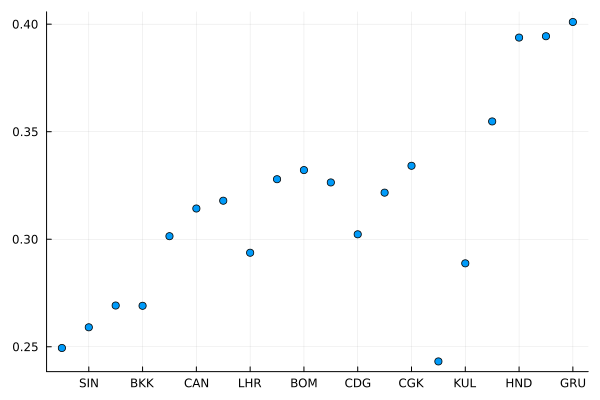

In [63]:
using CSV
using DataFrames
using Plots
using LaTeXStrings

function get_airport_code_from_population_size(population_size,population_sizes_dict)
    for (code, size) in population_sizes_dict
        if population_sizes_dict[code] == population_size
            # println(code)
            return code
        end
    end
    return none
end

# Load the analysis results
analysis_results = DataFrame(CSV.File("analysis_results.csv"))

# Initialize an empty dictionary to map airport codes to survival probabilities
code_to_survival = Dict()

for row in eachrow(analysis_results)
    # Get the population size using the OutbreakDeme index from population_sizes_vector
    population_size = population_sizes_vector[row.OutbreakDeme]
    
    # Find the airport code that matches this population size in the population_sizes dictionary
    airport_code = get_airport_code_from_population_size(population_size, population_sizes)
    # println(airport_code)
    
    # Map this airport code to the survival probability
    code_to_survival[airport_code] = row.SurvivalProbability
end

# Specify the order of airport codes for plotting
specified_order = ["HKG", "SIN", "PEK", "BKK", "PVG", "CAN", "CTU", "LHR", "DEL", "BOM", "LAX", "CDG", "MNL", "CGK", "AMS", "KUL", "ATL", "HND", "DEN", "GRU"]
specified_order = ["AMS", "LHR", "PEK", "HKG", "BKK", "PVG", "CDG", "ATL", "SIN", "CTU", "LAX", "DEL", "BOM", "DEN", "CAN", "KUL", "MNL", "GRU", "CGK", "HND"]

# Extract the survival probabilities in the specified order
ordered_survival_probabilities = [code_to_survival[code] for code in specified_order]

# Plotting
plot(specified_order, ordered_survival_probabilities, seriestype=:bar,
     legend=false,
     ylabel=L"Survival\ Probability", xlabel="Airport Code",
     title="Survival Probability by Airport Code",
     color=:blue, xrotation=90, size=(960, 480),
     tickfont=font(10, "Computer Modern"), legendfont=font(10, "Computer Modern"),
     guidefont=font(12, "Computer Modern"), titlefont=font(14, "Computer Modern"))

scatter(specified_order, ordered_survival_probabilities,legend=false)


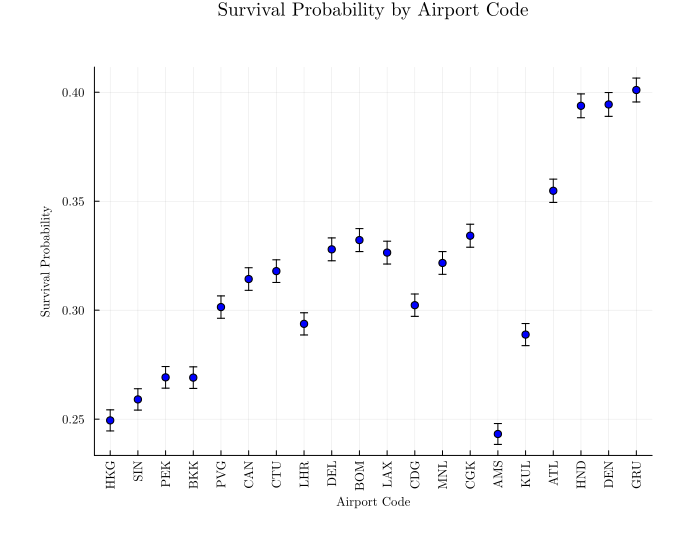

"code_to_survival_mapping_aligned.csv"

In [64]:
using Plots
using CSV
using DataFrames
using LaTeXStrings

# Convert specified_order to numerical positions
x_positions = 0.1 * (1:length(specified_order))

# Adjusted plotting code with aligned markers
p = scatter(x_positions, ordered_survival_probabilities, legend=false,
        labels=false, # No legend
        ylabel="Survival Probability", xlabel="Airport Code",
        title="Survival Probability by Airport Code",
        markersize=4, color=:blue,
        xticks=(x_positions, specified_order),  # Custom x-axis ticks to align with markers
        xrotation=90, size=(700, 550),
        tickfont=font(8, "Computer Modern"), legendfont=font(8, "Computer Modern"),
        guidefont=font(8, "Computer Modern"), titlefont=font(12, "Computer Modern"),
        yerror=sqrt.(ordered_survival_probabilities .* (1 .- ordered_survival_probabilities)/8001),
        margin=40Plots.px,
        )

display(p)
# Save the plot
savefig(p, "survival_probability_scatter_plot.png")

# Save the mapping between codes and survival probabilities to a CSV
mapping_df = DataFrame(AirportCode = specified_order, SurvivalProbability = ordered_survival_probabilities)
CSV.write("code_to_survival_mapping_aligned.csv", mapping_df)


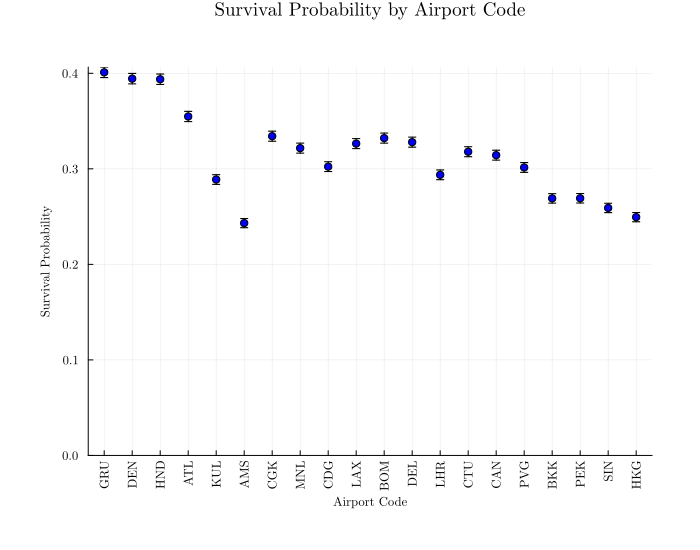

"code_to_survival_mapping_aligned.csv"

In [102]:
using Plots
using CSV
using DataFrames
using LaTeXStrings

# Convert specified_order to numerical positions
x_positions = 0.1 * (1:length(specified_order))

# Adjusted plotting code with aligned markers
p = scatter(reverse(x_positions), ordered_survival_probabilities, legend=false,
        labels=false, # No legend
        ylabel="Survival Probability", xlabel="Airport Code",
        title="Survival Probability by Airport Code",
        markersize=4, color=:blue,
        xticks=(reverse(x_positions), specified_order),  # Custom x-axis ticks to align with markers
        xrotation=90, size=(700, 550),
        tickfont=font(8, "Computer Modern"), legendfont=font(8, "Computer Modern"),
        guidefont=font(8, "Computer Modern"), titlefont=font(12, "Computer Modern"),
        yerror=sqrt.(ordered_survival_probabilities .* (1 .- ordered_survival_probabilities)/8001),
        margin=40Plots.px,
        ylims=[0, Inf]
        )

display(p)
# Save the plot
savefig(p, "survival_probability_scatter_plot.png")

# Save the mapping between codes and survival probabilities to a CSV
mapping_df = DataFrame(AirportCode = specified_order, SurvivalProbability = ordered_survival_probabilities)
CSV.write("code_to_survival_mapping_aligned.csv", mapping_df)


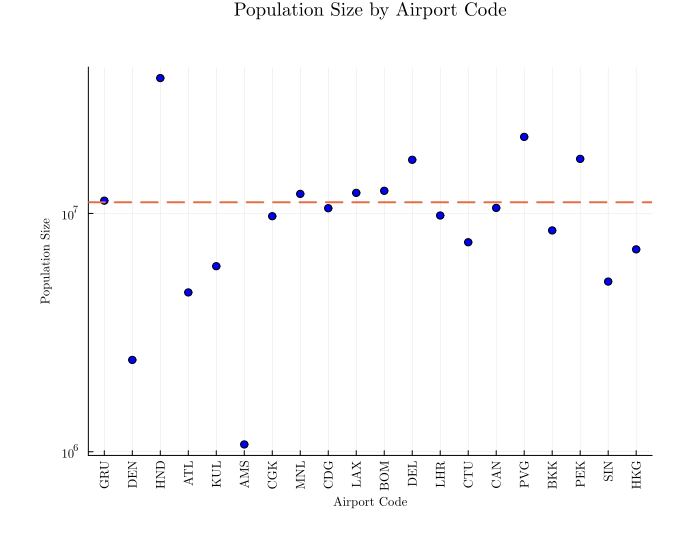

In [66]:
using Statistics
ordered_population_sizes = [population_sizes[code] for code in specified_order]

p = scatter(reverse(x_positions), ordered_population_sizes, legend=false,
        labels=false, # No legend
        ylabel="Population Size", xlabel="Airport Code",
        title="Population Size by Airport Code",
        markersize=4, color=:blue,
        xticks=(reverse(x_positions), specified_order),  # Custom x-axis ticks to align with markers
        xrotation=90, size=(700, 550),
        tickfont=font(8, "Computer Modern"), legendfont=font(8, "Computer Modern"),
        guidefont=font(8, "Computer Modern"), titlefont=font(12, "Computer Modern"),
        yerror=sqrt.(ordered_survival_probabilities .* (1 .- ordered_survival_probabilities)/6001),
        margin=40Plots.px,
        yscale=:log10
        )
hline!(p,[mean(ordered_population_sizes)],linestyle=:dash, linewidth=2)
display(p)

In [99]:
y = rand(10,10)
x = vec(sum(y, dims=1))
findfirst(x.>0.4)

1

In [101]:
A = rand(40)
count(A .> 0.6)

13

In [88]:
length(size(A))

2